# Studying covariation using two-block partial least-squares

## Introduction
Partial least-squares (PLS) is a [family of techniques](http://staff.ustc.edu.cn/~zwp/teach/Reg/overview_pls.pdf) for studying and modelling relations among multivariate data-sets. The terminology can get confusing so, to be clear, when I say 'two-block-pls' I refer those pls methods that:

1. Model the relationship between exactly two blocks of variables (although extensions exist to model relationships among more than 2 blocks).
2. Are symmetrical (the X and Y blocks could be interchanged without altering the results).
3. Usually the goal of the analysis is to extract and interpret the patterns of covariation, as opposed to prediction (e.g. of Y from X). For prediction variants that emphasize explaining one block from the other are more appropriate.

Python_shape_stats PLS_2B and ShapePLS_2B classes implement implement the 'PLS-SB' algoriths in the terminology of the [review](http://staff.ustc.edu.cn/~zwp/teach/Reg/overview_pls.pdf), although 'PLS-Mode-A' is also symmetric and would also be appropriate here.  'PLS-SB' is the same algorithm as 'PLSSVD' in [scipy](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSSVD.html).

### Note
I use a Jupyter notebook to easily move between code snippets and dicussion. However some limitations in how pyvista cooperates with Jupyter means that some of the visualisation methods don't work properly when run inisde Jupyter. I advise you to also copy the code snippets consecutively into a .py file and run either from the terminal or in an IDE like PyCharm or Spyder.


## Two-block PLS for studying covariation between two related structures
[Two block pls in shape analysis](https://doi.org/10.1080/106351500750049806) is often used to study the patterns of covariation that exist between related structures. For example [Young et.al](https://doi.org/10.1016/j.ajodo.2015.09.028) studied the relationship between the facial surface and the underlying skeleton. This first part of the notebook uses the example of studying covariation between the shape of the human nose and the human forehead

### Step 1: Generalized Procrustes analysis
After importing the relevant packages and loading the data ...=

In [4]:
##
from python_shape_stats import helpers, procrustes
from python_shape_stats.statistical_shape_models import ShapePCA,ShapePLS_2B
import glob
import os
import numpy as np



# load the nose and forehead datasets
nose_path = helpers.get_path_to_simulated_noses() # get path to the relevant package data
nose_obj_paths = glob.glob(os.path.join(nose_path,'*.obj'))
if len(nose_obj_paths)==0:
    Warning('Dataset not found')
forehead_path = helpers.get_path_to_simulated_foreheads()
forehead_obj_paths = glob.glob(os.path.join(forehead_path,'*.obj'))
if len(forehead_obj_paths)==0:
    Warning('Dataset not found')

# check the filenames are matching (specimen A in one dataset is the same as in the other)
assert all([os.path.split(nose_obj_paths[x])[1] == os.path.split(forehead_obj_paths[x])[1] for x in range(len(forehead_obj_paths))])

# load each dataset into a numpy array and a list of polydatas
x_vertices,x_polydatas = helpers.load_shapes_to_array(nose_obj_paths)
y_vertices,y_polydatas = helpers.load_shapes_to_array(forehead_obj_paths)


Output()

Output()

...the first thing we need to do is align all the samples into a common coordinate system (see the notebook on Procrustes analysis for more details). For this we have two options and these depend on the goal of the study.
1. If how structure a is positioned relative to structure b is important then you want to treat the points representing a and b as single block for superimposition (set SUPER_TYPE to 'joint').
2. If not, and you are only interested in how the shape of one structure covaries with another, ignoring how they are positioned relative to each other, then you want to superimpose the blocks separately (SUPER_TYPE = 'separate')

In [5]:
# Co-align specimens
SUPER_TYPE = 'joint'
if SUPER_TYPE == 'joint':
    n_landmarks_x = x_vertices.shape[0]
    n_landmarks_y = y_vertices.shape[0]
    # concatenate the vertices
    cat_lms = np.vstack([x_vertices,y_vertices])
    # do GPA on the landmarks together
    aligned_lms,mean_lms = procrustes.do_generalized_procrustes_analysis(cat_lms)
    # split them into two blocks again
    X = aligned_lms[:n_landmarks_x]
    Y = aligned_lms[n_landmarks_x:]
    Xmean = mean_lms[:n_landmarks_x]
    Ymean = mean_lms[n_landmarks_x:]
elif SUPER_TYPE == 'separate':
    X,Xmean = procrustes.do_generalized_procrustes_analysis(x_vertices)
    Y,Ymean = procrustes.do_generalized_procrustes_analysis(y_vertices)
else:
    raise ValueError('not a valid \'SUPER_TYPE\'')


Output()

Begin generalized Procrustes analysis
Iteration 0


Output()

Iteration 1


Output()

RMS difference =2.1522801962460126e-07
Iteration 2


RMS difference =2.1481060567812245e-07
algorithm converged


## Step 2: Principal components analysis
Next we need to create two instances of the 'ShapePCA' class, one representing shape variation in the nose, and one representing shape variation in the forehead. The two blocks in 2B-PLS analysis will be the principal component scores. While doing PCA prior to 2B-PLS is not strictly necessary:
1. The implementation in python_shape_stats assumes this is how the shapes will be represented.
2. It is usually drastically more efficient when the analysis is done on PC scores rather than the raw data especially when the number of features is large.


In [6]:
# this is not a situation in which the number of PCs retained is especially crucial. The main risk
# is that if you exclude too many you might lose some interesting information. So set a high threshold is my advice...
PCT_VAR = 99.9 # retain PCs explaining up to 99.9% of the total variation

# make PCA model of x
PCA_X = ShapePCA()
PCA_X.fit_transform(X,center_config=Xmean,center=True)
# reduce dimensions
PCA_X.trim_perc_var(PCT_VAR)

#make PCA model of y
PCA_Y = ShapePCA()
PCA_Y.fit_transform(Y,center_config = Ymean,center=True)
PCA_Y.trim_perc_var(PCT_VAR)

# for later we will want to visualise meshes as surface, for this we need the faces of the polydata, which we will attach to each ShapePCA by giving it a reference polydata object (an example mesh from each dataset)

PCA_Y.reference_polydata = y_polydatas[0]
PCA_X.reference_polydata = x_polydatas[0]



### Step 3 fit two block PLS model
Now we can fit the two block PLS model between X and Y. Strictly speaking this fits the model to the pc scores i.e. it fits the model between PCA_X.transformed_training_data and PCA_Y.transformed_training_data

In [7]:
PLSMod = ShapePLS_2B()
PLSMod.fit(PCA_X,PCA_Y)

### Step 4 how many PLS dimensions are interesting
Two block PLS reveals how block X covaries with block Y. It finds combinations of the x and y variables that are maximally associated with each other. Each successive dimension explains less and less covariation. We need to know how many of these are real signal and which are noise. One way to do this is via a permutation test:

The covariance explained by each pair of latent dimensions is kept in the attribute PLSMod.cov_explained. To determine if this is more than expected by chance we can see what would happen if there was no relationship between X and Y  and compare the observed values to that. Essentially we permute the rows of the X-block n times and fit a PLS_2B model to the simulated data. By doing so we build up a 'null' distribution that can be compared to the observed values.

In [8]:
# run the permutation test with 1000 repetitions
PLSMod.compute_null_distribution(n_reps=1000)
# the result is kept in PLSMod._permutation_null_distribution


Output()

A 'p value' for each dimension can then be calculated. This is for what proportion of repetitions the null values were greater than the observed values. It is common to accept  only those dimensions with p values < .05.

In [9]:
print(PLSMod.perm_test_p_values)

[0.    0.    0.    0.001 0.    0.004 0.    0.    0.   ]


And we can also plot how the observed values sit in relation to the null.

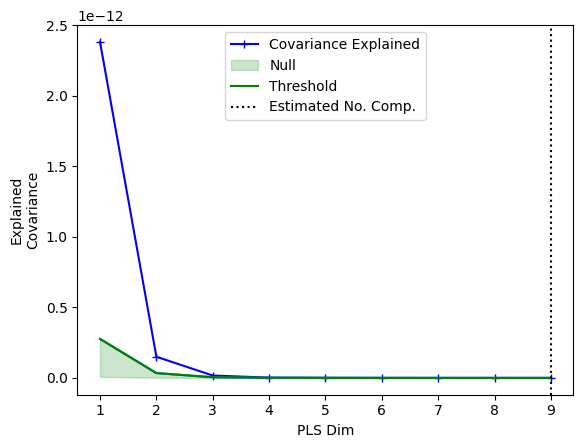

In [7]:
PLSMod.permutation_test_plot(p_crit=.05)

All dimensions are significant, however we can see that the first two explain much much more covariation than the remainder. These are likely to be the most interesting to look at. You can visualise pairs of latent dimensions as paired color-maps.

### Step 5 Visualising the interesting dimensions
As I mentioned above neither method of plotting colormaps or making animations work properly from inside Jupyter. To get the following

In [11]:
# plot in the same viewer if they are in the same coordinate system
if SUPER_TYPE == 'joint':
    same_coordinate_system = True
else:
    same_coordinate_system = False

# make colormap
dim = 1 # e.g. plot the first dimension
PLSMod.colormap_latent_dim(dim,link_views=False,same_coordinate_system=same_coordinate_system,direction='normal')


Widget(value="<iframe src='http://localhost:53683/index.html?ui=P_0x17d12dcc0_0&reconnect=auto' style='width: …

In [12]:
# make animation
PLSMod.animate_latent_dim(1,link_views=False,same_coordinate_system=same_coordinate_system)


ValueError: operands could not be broadcast together with shapes (20,) (1,9) 

 **NOTE: if you run the above command in a python script (not a jupyter notebook), run in an IDE like PyCharm or Spyder, typing 'k' will trigger the animation to start and save it as a gif. This also doesn't work from jupyter, so here's one I prepared earlier**
 ![SegmentLocal](/Users/hmatth5/Documents/Projects/python_shape_stats/docs/source/usage/examples/notebooks/Two-Block_PLS/images/PLS_Dim1.gif "segment")